In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [2]:
ratings_df = pd.read_csv('data/ratings.csv')
to_read_df = pd.read_csv('data/to_read.csv')
books_df = pd.read_csv('data/books.csv')
tags_df = pd.read_csv('data/tags.csv')
book_tags_df = pd.read_csv('data/book_tags.csv')

In [3]:
ratings_df

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


<font size="5">Explaining the model</font>
<br>
<font size="3">The idea is that we will learn some 
latent features about each user and each book. The latent features are 
represented by a neural network.
When doing prediction, the dot product between those latent features
will be the predicted rating for a given user book pair.</font>

In [4]:
from keras.layers import Embedding, Input, dot, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import adam_v2

In [5]:
# The number of latent factors for the embedding
n_latent_factors = 10

# no of users and movies
n_users, n_movies = len(ratings_df['user_id'].unique())+1, len(ratings_df['book_id'].unique())+1

In [6]:
# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Book_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Book_Embedding') (movie_input)
movie_vector = Flatten(name='Book_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Book_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        534250      ['User_Input[0][0]']             
                                                                                                  
 Book_Embedding (Embedding)     (None, 1, 10)        100010      ['Book_Input[0][0]']             
                                                                                              

<font size="3">Due to the limitation of the computing resources on an old laptop
we cannot train the neural network with all the given rating data.
We will randomly sample entries from the given rating data and form a smaller data
set to train the neural network. 
We will repeat this process several times and in the end.
We will form an ensemble of neural networks to predict book rating of an inqury user.</font>

In [8]:


sample_size = 2000000
sampled_index = random.sample(range(ratings_df.shape[0]), sample_size)
sampled_data = ratings_df.iloc[sampled_index]

X = sampled_data.iloc[:,:2]
Y = sampled_data.iloc[:,2]

#split the sampled data into testing, validation, and training
x_other, x_test, y_other, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_other, y_other, test_size = 0.1, random_state = 1)


#train the model with early stopping
optimizer = adam_v2.Adam(learning_rate = 0.0005)
model.compile(loss='mean_squared_error', optimizer = optimizer)
batch_size = 5000
epochs = 200
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x=[x_train['user_id'], x_train['book_id']], y=y_train, batch_size= batch_size, 
                    epochs=epochs,verbose= 2, 
                    validation_data=([x_val['user_id'], x_val['book_id']], y_val),
                    callbacks=[callback])

Epoch 1/200
324/324 - 4s - loss: 16.3464 - val_loss: 16.3244 - 4s/epoch - 12ms/step
Epoch 2/200
324/324 - 4s - loss: 16.2774 - val_loss: 16.0574 - 4s/epoch - 12ms/step
Epoch 3/200
324/324 - 3s - loss: 15.1852 - val_loss: 13.9210 - 3s/epoch - 10ms/step
Epoch 4/200
324/324 - 3s - loss: 12.1483 - val_loss: 10.3616 - 3s/epoch - 11ms/step
Epoch 5/200
324/324 - 4s - loss: 8.5524 - val_loss: 7.0066 - 4s/epoch - 12ms/step
Epoch 6/200
324/324 - 3s - loss: 5.6216 - val_loss: 4.5912 - 3s/epoch - 9ms/step
Epoch 7/200
324/324 - 3s - loss: 3.6980 - val_loss: 3.1192 - 3s/epoch - 9ms/step
Epoch 8/200
324/324 - 3s - loss: 2.5733 - val_loss: 2.2694 - 3s/epoch - 11ms/step
Epoch 9/200
324/324 - 3s - loss: 1.9178 - val_loss: 1.7588 - 3s/epoch - 10ms/step
Epoch 10/200
324/324 - 3s - loss: 1.5143 - val_loss: 1.4342 - 3s/epoch - 9ms/step
Epoch 11/200
324/324 - 3s - loss: 1.2540 - val_loss: 1.2203 - 3s/epoch - 9ms/step
Epoch 12/200
324/324 - 3s - loss: 1.0814 - val_loss: 1.0761 - 3s/epoch - 9ms/step
Epoch 13/2

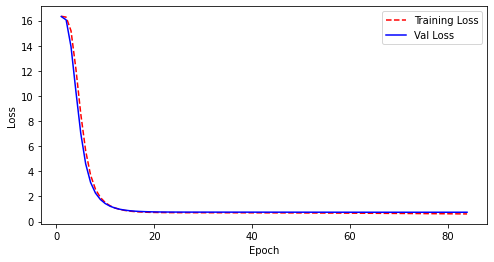

In [9]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [10]:
#test the model on unseen data
score = model.evaluate([x_test['user_id'], x_test['book_id']], y_test)

print()
print('MSE: {:.4f}'.format(score))

6250/6250 [==============================] - 14s 2ms/step - loss: 0.7357

MSE: 0.7357


In [11]:
model.save("neural_networks_embedding_1.h5")

In [12]:
# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Book_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Book_Embedding') (movie_input)
movie_vector = Flatten(name='Book_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)


sample_size = 2000000
sampled_index = random.sample(range(ratings_df.shape[0]), sample_size)
sampled_data = ratings_df.iloc[sampled_index]

X = sampled_data.iloc[:,:2]
Y = sampled_data.iloc[:,2]

#split the sampled data into testing, validation, and training
x_other, x_test, y_other, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_other, y_other, test_size = 0.1, random_state = 1)


#train the model with early stopping
optimizer = adam_v2.Adam(learning_rate = 0.0005)
model.compile(loss='mean_squared_error', optimizer = optimizer)
batch_size = 5000
epochs = 200
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x=[x_train['user_id'], x_train['book_id']], y=y_train, batch_size= batch_size, 
                    epochs=epochs,verbose= 2, 
                    validation_data=([x_val['user_id'], x_val['book_id']], y_val),
                    callbacks=[callback])

Epoch 1/200
324/324 - 4s - loss: 16.3519 - val_loss: 16.3495 - 4s/epoch - 13ms/step
Epoch 2/200
324/324 - 3s - loss: 16.2201 - val_loss: 15.8982 - 3s/epoch - 11ms/step
Epoch 3/200
324/324 - 4s - loss: 14.9042 - val_loss: 13.6261 - 4s/epoch - 12ms/step
Epoch 4/200
324/324 - 3s - loss: 11.8779 - val_loss: 10.1478 - 3s/epoch - 9ms/step
Epoch 5/200
324/324 - 3s - loss: 8.3745 - val_loss: 6.8655 - 3s/epoch - 9ms/step
Epoch 6/200
324/324 - 4s - loss: 5.5084 - val_loss: 4.4946 - 4s/epoch - 11ms/step
Epoch 7/200
324/324 - 4s - loss: 3.6226 - val_loss: 3.0504 - 4s/epoch - 12ms/step
Epoch 8/200
324/324 - 3s - loss: 2.5203 - val_loss: 2.2196 - 3s/epoch - 10ms/step
Epoch 9/200
324/324 - 3s - loss: 1.8798 - val_loss: 1.7230 - 3s/epoch - 10ms/step
Epoch 10/200
324/324 - 3s - loss: 1.4873 - val_loss: 1.4093 - 3s/epoch - 9ms/step
Epoch 11/200
324/324 - 3s - loss: 1.2350 - val_loss: 1.2035 - 3s/epoch - 10ms/step
Epoch 12/200
324/324 - 4s - loss: 1.0681 - val_loss: 1.0651 - 4s/epoch - 11ms/step
Epoch 13

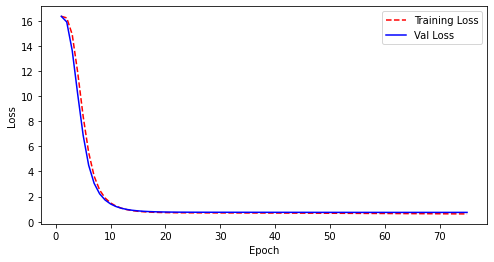

In [13]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
#test the model on unseen data
score = model.evaluate([x_test['user_id'], x_test['book_id']], y_test)

print()
print('MSE: {:.4f}'.format(score))

6250/6250 [==============================] - 14s 2ms/step - loss: 0.7424

MSE: 0.7424


In [15]:
model.save("neural_networks_embedding_2.h5")